#### IMPORTS

In [405]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mtp
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.model_selection import KFold, LeaveOneOut

#### PARAMS

In [406]:
metrics = {
    "euclidean": lambda p1, p2: np.sqrt(sum([pow(p1[i] - p2[i], 2) for i in range(len(p1))])),
    "manhattan": lambda p1, p2: sum([abs(p1[i] - p2[i]) for i in range(len(p1))]),
    "chebyshev": lambda p1, p2: max([abs(p1[i] - p2[i]) for i in range(len(p1))]),
}

kernels = {
    "uniform": lambda x: 0.5,
    "triangular": lambda x: 1 - abs(x),
    "epanechnikov": lambda x: 0.75 * (1 - pow(x, 2)),
    "quartic": lambda x: 15 / 16 * pow(1 - pow(x, 2), 2),
}

windows = {
    'fixed': [0.1, 1, 2 , 3, 4],
    # 'variable': [], processed in runtime
}

#### PARAMETER

In [407]:
parameter = 'class'

#### DATA RAW

In [408]:
# data_raw = pd.read_csv('cars.csv')[['lug_boot', 'safety', 'class']].sample(frac=1)
data_raw = pd.read_csv('data/cars.csv').sample(frac=1)[:50]
print(data_raw)

data_raw_X = data_raw.drop([parameter], axis=1)
data_raw_Y = data_raw[parameter]

     buying  maint  doors persons lug_boot safety  class
350   vhigh    low      2    more      big   high    acc
1140    med    med      4       2      big    low  unacc
910     med  vhigh      3    more    small    med  unacc
1247    med    low      4       2      med   high  unacc
833    high    low      4    more      med   high    acc
1632    low    low      2       4      med    low  unacc
1403    low  vhigh  5more    more      big   high    acc
524    high  vhigh  5more       4    small   high  unacc
1710    low    low  5more       4    small    low  unacc
317   vhigh    med  5more    more    small   high    acc
42    vhigh  vhigh      3       4      big    low  unacc
1682    low    low      4       2      big   high  unacc
1485    low   high  5more       2    small    low  unacc
371   vhigh    low      3    more    small   high    acc
214   vhigh   high  5more    more      big    med  unacc
685    high    med      3       4    small    med  unacc
1255    med    low      4      

#### DATA PROCESSED


In [409]:
data_processed_X = data_raw_X.apply(lambda x: pd.factorize(x)[0])
print(data_processed_X)
print(data_processed_X.corr())

one_hot = OneHotEncoder(sparse=False)
data_processed_Y = one_hot.fit_transform(data_raw_Y.values.reshape(-1, 1))
# print(data_processed_Y)

      buying  maint  doors  persons  lug_boot  safety
350        0      0      0        0         0       0
1140       1      1      1        1         0       1
910        1      2      2        0         1       2
1247       1      0      1        1         2       0
833        2      0      1        0         2       0
1632       3      0      0        2         2       1
1403       3      2      3        0         0       0
524        2      2      3        2         1       0
1710       3      0      3        2         1       1
317        0      1      3        0         1       0
42         0      2      2        2         0       1
1682       3      0      1        1         0       0
1485       3      3      3        1         1       1
371        0      0      2        0         1       0
214        0      3      3        0         0       2
685        2      1      2        2         1       2
1255       1      0      1        2         2       2
1723       3      0      3  

#### NORMALIZE

In [410]:
data_normalized_X = normalize(data_processed_X)
# print(data_normalized_X)

#### PROCESS WINDOW

In [411]:
rD = np.max([metrics.get('euclidean')(a, b) for a in data_normalized_X for b in data_normalized_X])
sqrtD = np.sqrt(len(data_normalized_X))
step = rD / sqrtD
print(rD, sqrtD, step)

windows['variable'] = [i for i in np.arange(step, rD, step)]

1.4142135623730951 7.0710678118654755 0.2


#### CLASSES

In [412]:
classes = len(np.unique(data_raw[parameter].values))
print(classes)

4


#### PREPARE DATA

In [413]:
data_length = len(data_raw)
data = np.array([[data_normalized_X[i], data_processed_Y[i]] for i in range(data_length)])

C:\Temp\ipykernel_1868\3400568675.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([[data_normalized_X[i], data_processed_Y[i]] for i in range(data_length)])


#### REGRESSION

In [414]:
def regression(x_test,
               data_train,
               dist_fun=metrics.get('euclidean'),
               kernel_fun=kernels.get('uniform'),
               w=windows.get('fixed')[0]):
    up, down = 0, 0
    for (xi, yi) in data_train:
        k = kernel_fun(dist_fun(xi, x_test) / w)
        up += k * yi
        down += k
    return up / down


def get_component(arr):
    max_element = max(arr)
    return list(map(lambda x: 1 if x == max_element else 0, arr))

#### TRUE FALSE NEGATIVE POSITIVE

In [415]:
def tfnp(must, trained):
    tp, tn, fp, fn = [0] * classes, [0] * classes, [0] * classes, [0] * classes
    for i in range(len(trained)):
        for j in range(classes):
            if trained[i][j] == 1 and must[i][j] == 1:
                tp[j] += 1
            elif trained[i][j] == 1 and must[i][j] == 0:
                fp[j] += 1
            elif trained[i][j] == 0 and must[i][j] == 1:
                fn[j] += 1
            else:
                tn[j] += 1
    return tp, tn, fp, fn

#### F1 SCORE

In [416]:
def precision(tp, fp):
    return get_prec_or_rec(tp, fp)


def recall(tp, fn):
    return get_prec_or_rec(tp, fn)


def get_prec_or_rec(a, b):
    if a + b == 0:
        return 0
    return a / (a + b)


def f1_score(prec, rec):
    if prec + rec == 0:
        return 0
    return 2 * (prec * rec) / (prec + rec)

#### FUNCTION WITH HYPER PARAMETERS

In [417]:
def get_score(train, test, get_dist, get_kernel, w):
    res_expected = []
    res = []
    for ((train_x, train_y), (test_x, test_y)) in zip(train, test):
        test_y_predicted = regression(train_x, test, get_dist, get_kernel, w)
        res_expected.append(test_y)
        res.append(get_component(test_y_predicted))

    tp, tn, fp, fn = tfnp(res_expected, res)
    return np.average([f1_score(precision(tp[i], fp[i]), recall(tp[i], fn[i])) for i in range(classes)])

#### RESULTS

In [418]:
kf = KFold(n_splits=3)
l = LeaveOneOut()

best_score = 0
best_params = []

for metric_key in metrics.keys():
    for kernel_key in kernels.keys():
        for window_key in windows.keys():
            for window in windows.get(window_key):
                print('|', end='')
                scores = []
                for train_index, test_index in l.split(data):
                    train_data, test_data = data[train_index], data[test_index]
                    score = get_score(
                        train_data,
                        test_data,
                        metrics.get(metric_key),
                        kernels.get(kernel_key),
                        window,
                    )
                    scores.append(score)
                average_score = np.average(scores)
                if average_score > best_score:
                    best_score = average_score
                    best_params = [metric_key, kernel_key, window_key, window]
print('\n', best_score, best_params)

||||||||||||||||||||||||||||||||||

C:\Temp\ipykernel_1868\1646301138.py:11: RuntimeWarning: invalid value encountered in true_divide
  return up / down


||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 0.25 ['euclidean', 'uniform', 'fixed', 0.1]


#### PLOT BUILD

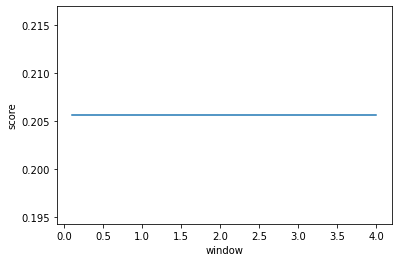

In [419]:
points_x, points_y = [], []

for window in windows.get(best_params[2]):
    scores = []
    for train_index, test_index in kf.split(data):
        train_data, test_data = data[train_index], data[test_index]
        score = get_score(
            train_data,
            test_data,
            metrics.get(best_params[0]),
            kernels.get(best_params[1]),
            window,
        )
        scores.append(score)
    average_score = np.average(scores)

    points_x.append(window)
    points_y.append(average_score)

mtp.xlabel("window")
mtp.ylabel("score")
mtp.plot(points_x, points_y)
mtp.show()